In [29]:
## ABALONE
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
import pickle

# Data Processing

In [30]:
data = pd.read_csv('abalone.data',
         names=['sex','length','diameter','height','wholeWeight','shuckedWeight','visceraWeight','shellWeight','rings'],delimiter=',')

In [31]:
x1 = data['sex'].to_numpy()
x2 = data['length'].to_numpy(np.float64)
x3 = data['diameter'].to_numpy(np.float64)
x4 = data['height'].to_numpy(np.float64)
x5 = data['wholeWeight'].to_numpy(np.float64)
x6 = data['shuckedWeight'].to_numpy(np.float64)
x7 = data['visceraWeight'].to_numpy(np.float64)
x8 = data['shellWeight'].to_numpy(np.float64)
y = data['rings'].to_numpy(np.float64)

#getting x1 code
x1_code = np.empty(len(y))


In [32]:
enc = OneHotEncoder()
x1_OH = enc.fit_transform(x1.reshape(-1, 1))
print(x1[0:9])
x1_OH.toarray()[0]

['M' 'M' 'F' 'M' 'I' 'I' 'F' 'F' 'M']


array([0., 0., 1.])

(4177,)

In [35]:
dataArr = np.empty([0,10])

for i in range(len(x2)):
    x1_temp = np.empty([0,3])
    x1_temp = np.append(x1_temp,x1_OH.toarray()[i])
    row = np.array([x1_temp[0],x1_temp[1],x1_temp[2],x2[i],x3[i],x4[i],x5[i],x6[i],x7[i],x8[i]])
    dataArr = np.append(dataArr,np.array([row]),axis=0)
dataArr

array([[0.    , 0.    , 1.    , ..., 0.2245, 0.101 , 0.15  ],
       [0.    , 0.    , 1.    , ..., 0.0995, 0.0485, 0.07  ],
       [1.    , 0.    , 0.    , ..., 0.2565, 0.1415, 0.21  ],
       ...,
       [0.    , 0.    , 1.    , ..., 0.5255, 0.2875, 0.308 ],
       [1.    , 0.    , 0.    , ..., 0.531 , 0.261 , 0.296 ],
       [0.    , 0.    , 1.    , ..., 0.9455, 0.3765, 0.495 ]])

In [36]:
## scale output data
scaler = MinMaxScaler((0, 1))
y_shape = y.shape
y = scaler.fit_transform(y.reshape(-1, 1))
y = y.reshape(y_shape)

In [37]:
y = y.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(dataArr, y, test_size=0.33, random_state=42) 

## Neural Network 

In [38]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt

In [39]:
## Scaled output network
inputs = 10
firstLayer = 60
output = 1

net = torch.nn.Sequential(
        torch.nn.Linear(inputs, firstLayer),
        torch.nn.Sigmoid(),
        torch.nn.Linear(firstLayer, output),
        )

In [41]:

optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
# loss_func = torch.nn.MSELoss(reduction='mean')  # this is for regression mean squared loss ---> can change to sum. Is mean currently
loss_func = torch.nn.MSELoss(reduction='mean')

BATCH_SIZE = 1399#len(x_train)#700 
EPOCH = 1500

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()


torch_dataset = Data.TensorDataset(x_train, y_train)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2,)

In [42]:
# Pytorch Grad Descent
# loss_graph = torch.empty(0)
# start_time = time.perf_counter()
# for epoch in range(EPOCH):
#     for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
#         b_x = Variable(batch_x,requires_grad=False)
#         b_y = Variable(batch_y)

#         y_pred = net(b_x.float())     # input x and predict based on x
        
# #         loss =  loss_func(y_pred, b_y)     # must be (1. nn output, 2. target)
# #         loss_graph = torch.cat((loss_graph, loss.detach().flatten()),0)
        
#         ##Scaled Output Change
#         loss1 =  loss_func(torch.from_numpy(scaler.inverse_transform(y_pred.detach().numpy())), torch.from_numpy(scaler.inverse_transform(b_y.detach().numpy()))) 
#         loss =  loss_func(y_pred, b_y) 
#         loss_graph = torch.cat((loss_graph, loss.detach().flatten()),0) 
#         print("error at epoch ",epoch,"is ",loss)

# #         print("epoch: ",epoch," loss: ",loss.detach().numpy())
#         optimizer.zero_grad()   # clear gradients for next train
#         loss.backward()         # backpropagation, compute gradients
#         optimizer.step()        # apply gradients
    
#     if ((loss_graph[2*epoch+1]+loss_graph[2*epoch])/2 <0.006):
#         break
        
# print("time taken to execute: ",time.perf_counter()-start_time) 
# plt.plot(loss_graph.numpy()) 
# pickle.dump(loss_graph, open( "RSS_GD.p", "wb" ))

## LM

error at epoch  0 is  tensor(0.1966)
error at epoch  0 is  tensor(0.0080)
error at epoch  1 is  tensor(0.0088)
error at epoch  1 is  tensor(0.0064)
error at epoch  2 is  tensor(0.0061)
error at epoch  2 is  tensor(0.0102)
error at epoch  3 is  tensor(0.0052)
error at epoch  3 is  tensor(0.0077)
error at epoch  4 is  tensor(0.0053)
error at epoch  4 is  tensor(0.0081)
error at epoch  5 is  tensor(0.0054)
error at epoch  5 is  tensor(0.0064)
time taken to execute:  114.92419150000023


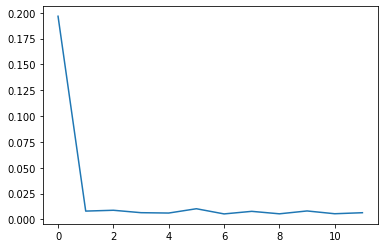

In [47]:
loss_graph = torch.empty(0)
u=0.1 #beta multiply identity matrix
b = 10
V_prev = 0 #intialise performance index
start_time = time.perf_counter()
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
        b_x = Variable(batch_x,requires_grad=False)
        b_y = batch_y.float()
        y_pred = net(b_x)     # predict outputs based on x
        num_param = inputs*firstLayer+firstLayer+firstLayer*output+output
        
        jacobian = torch.empty(len(batch_y), num_param) # errors by weights

        for n in range(len(batch_y)): #batch length is num of rows
            net.zero_grad()
            e = b_y[n]-y_pred[n]
            e.backward(retain_graph=True)
            with torch.no_grad():
                param_grads = torch.empty(0) 

                for param in net.parameters():
                    param_grads = torch.cat((param_grads, torch.flatten(param.grad).detach()),0) #puts gradient of params w.r.t e

                for m in range(num_param): #num params is num of coloumns
                    jacobian[n][m] = param_grads[m]
        with torch.no_grad():
            #determine dParam  
            V_current = 0.5*torch.sum(torch.square(b_y-y_pred)) #performance index
            if(V_current > V_prev):
                u *= b
            else:
                u /= b
            V_prev = V_current
#             print("V: ",V_current, "u is: ",u)
            dParam = torch.matmul(torch.matmul(torch.inverse(torch.matmul(torch.transpose(jacobian,-1,0),jacobian) + u*torch.eye(num_param, num_param)),torch.transpose(jacobian,-1,0)),b_y-y_pred)
            

            loss =  loss_func(y_pred, b_y) 
            loss_graph = torch.cat((loss_graph, loss.detach().flatten()),0) 
            print("error at epoch ",epoch,"is ",loss)

            #update the params
            c = 0
        with torch.no_grad():    
            for param in net.parameters():
                s = param.shape
                dParamUpdate = dParam[c:c+len(param.flatten())]
                c+= len(dParamUpdate)
                param -= 1*dParamUpdate.reshape(s)

            
    
    if ((loss_graph[2*epoch+1]+loss_graph[2*epoch])/2 <0.006):
        break
    
print("time taken to execute: ",time.perf_counter()-start_time)     
plt.plot(loss_graph.numpy())  
pickle.dump(loss_graph, open( "RSS_LM.p", "wb" ))

# Test Net

In [51]:
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()
y_pred = net(x_test)


In [52]:
y_test = y_test.numpy()
y_pred = y_pred.detach().numpy()

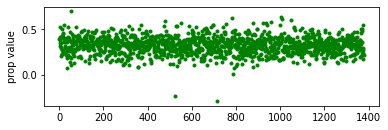

Error  1 is  0.1103383 correct was [0.2857143] predicted was  [0.3960526]
Error  2 is  0.06795347 correct was [0.25] predicted was  [0.31795347]
Error  3 is  0.10062501 correct was [0.2857143] predicted was  [0.3863393]
Error  4 is  0.052281946 correct was [0.4642857] predicted was  [0.41200376]
Error  5 is  0.09361996 correct was [0.21428572] predicted was  [0.30790567]
Error  6 is  0.11977413 correct was [0.17857143] predicted was  [0.29834557]
Error  7 is  0.32486343 correct was [0.75] predicted was  [0.42513657]
Error  8 is  0.056781456 correct was [0.2857143] predicted was  [0.22893284]
Error  9 is  0.028673887 correct was [0.25] predicted was  [0.2786739]
Error  10 is  0.14431995 correct was [0.60714287] predicted was  [0.4628229]
Error  11 is  0.061576188 correct was [0.35714287] predicted was  [0.41871905]
Error  12 is  0.05655083 correct was [0.4642857] predicted was  [0.40773487]
Error  13 is  0.12569708 correct was [0.6785714] predicted was  [0.5528743]
Error  14 is  0.14502

Error  316 is  0.075119674 correct was [0.39285713] predicted was  [0.31773746]
Error  317 is  0.04005553 correct was [0.17857143] predicted was  [0.21862696]
Error  318 is  0.088750854 correct was [0.21428572] predicted was  [0.30303657]
Error  319 is  0.13225254 correct was [0.2857143] predicted was  [0.41796684]
Error  320 is  0.042846918 correct was [0.25] predicted was  [0.29284692]
Error  321 is  0.039042026 correct was [0.32142857] predicted was  [0.28238654]
Error  322 is  0.016617827 correct was [0.10714286] predicted was  [0.12376069]
Error  323 is  0.12692821 correct was [0.53571427] predicted was  [0.40878606]
Error  324 is  0.035764724 correct was [0.32142857] predicted was  [0.28566384]
Error  325 is  0.08164233 correct was [0.35714287] predicted was  [0.4387852]
Error  326 is  0.1088932 correct was [0.32142857] predicted was  [0.21253537]
Error  327 is  0.3748115 correct was [0.14285715] predicted was  [-0.23195435]
Error  328 is  0.080869466 correct was [0.17857143] pre

Error  591 is  0.026041284 correct was [0.17857143] predicted was  [0.20461272]
Error  592 is  0.13271722 correct was [0.42857143] predicted was  [0.2958542]
Error  593 is  0.08685738 correct was [0.35714287] predicted was  [0.44400024]
Error  594 is  0.1177831 correct was [0.42857143] predicted was  [0.54635453]
Error  595 is  0.109188884 correct was [0.2857143] predicted was  [0.39490318]
Error  596 is  0.069538385 correct was [0.32142857] predicted was  [0.25189018]
Error  597 is  0.106757015 correct was [0.2857143] predicted was  [0.3924713]
Error  598 is  0.03254631 correct was [0.2857143] predicted was  [0.253168]
Error  599 is  0.025549293 correct was [0.21428572] predicted was  [0.23983501]
Error  600 is  0.09672052 correct was [0.5714286] predicted was  [0.47470808]
Error  601 is  0.07476187 correct was [0.5] predicted was  [0.42523813]
Error  602 is  0.07748645 correct was [0.10714286] predicted was  [0.1846293]
Error  603 is  0.115926504 correct was [0.25] predicted was  [0.

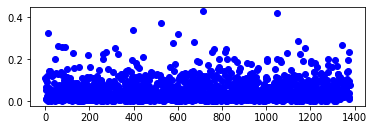

In [55]:
## Scaled output test
plt.subplot(2,1,1)

# plt.plot(y_pred.detach().numpy(),'g.')# , y_train,'r.')
plt.plot(y_pred,'g.')# , y_train,'r.')

plt.ylabel('prop value')
plt.show()

# loss = torch.empty(len(y_test)) 
loss = torch.empty(len(y_test)).numpy() 

c=0;
for i in range(len(y_test)):
#     loss[i] = torch.abs(y_test[i]-y_pred.detach().float().numpy()[i])
    loss[i] = abs(y_test[i]-y_pred[i])
    if loss[i] > (y_test[i]*0.1):
        c=c+1
        print("Error ", c ,"is ", loss[i], "correct was",y_test[i],"predicted was ",y_pred[i])

rmse = np.sqrt((((np.square(loss)).sum())/len(loss)))
        
        
plt.subplot(2,1,2)
plt.plot(loss,'bo')
print("avg loss was", loss.sum()/len(loss)," avg val is",y_test.sum()/len(y_test))
print("Minimum val is",min(y_test))
print("RMSE: ",rmse)
print("Test set length: ",len(y_test)," % of prdeictions within 10%: ",100-c/len(y_test)*100)

In [56]:
MSE = (np.square(loss))
print("MSE Mean: ",np.mean(MSE))
print("MSE STD Dev: ",np.std(MSE))


MSE Mean:  0.0060313903
MSE STD Dev:  0.0134351505
